In [1]:
import xarray as xr 
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xesmf as xe
from scipy.interpolate import griddata
import lenapy
import matplotlib.pyplot as plt

# Make tos

In [51]:
SST_DIR = '/projets/EMC2/data/Observations/SST/'

ersst_in = xr.open_dataset(f'{SST_DIR}/ERSSTv5.nc')
cobe2_in = xr.open_dataset(f'{SST_DIR}/COBE2.nc')
hadisst_in = xr.open_dataset(f'{SST_DIR}/HadISST_sst.nc')

null_mask = ((hadisst_in['sst'].notnull())).isel(time=0)
hadisst_in['sst'] = hadisst_in['sst'].where((hadisst_in['sst']>-100), -1.8)
hadisst_in['sst'] = hadisst_in['sst'].where(null_mask)

hadisst_in['mask'] = null_mask

grid_out_2deg = xr.Dataset({'lat': (['lat'], np.arange(-89, 90, 2.)),
                          'lon': (['lon'], np.arange(1, 360, 2.))})


regridder_hadisst = xe.Regridder(hadisst_in, grid_out_2deg, 'bilinear', periodic=True)
regridder_cobe2 = xe.Regridder(cobe2_in, grid_out_2deg, 'bilinear', periodic=True)
regridder_ersst = xe.Regridder(ersst_in, grid_out_2deg, 'bilinear', periodic=True) 

hadisst = regridder_hadisst(hadisst_in).sst
cobe2 = regridder_cobe2(cobe2_in).sst
ersst = regridder_ersst(ersst_in).sst

ersst = ersst.assign_coords(time=pd.date_range(f"{ersst.time.dt.year.values[0]}-{ersst.time.dt.month.values[0]}",freq='MS', periods=ersst.time.size))
cobe2 = cobe2.assign_coords(time=pd.date_range(f"{cobe2.time.dt.year.values[0]}-{cobe2.time.dt.month.values[0]}",freq='MS', periods=cobe2.time.size))
hadisst = hadisst.assign_coords(time=pd.date_range(f"{hadisst.time.dt.year.values[0]}-{hadisst.time.dt.month.values[0]}",freq='MS', periods=hadisst.time.size))

ds_tos = xr.concat([ersst.assign_coords(product='ERSSTv5'),
                    cobe2.assign_coords(product='COBE2'),
                    hadisst.assign_coords(product='HadISST'),],dim='product')

ds_tos = ds_tos.squeeze().drop_vars('lev')
ds_tos = ds_tos.sortby('lat', ascending=False)
ds_tos = ds_tos.where(ds_tos.count('product')==ds_tos.count('product').max())

grid_out_2deg['mask'] = ds_tos.isel(time=1000,product=0, drop=True).notnull().astype(int)

# GF compare

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'longitude_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'longitude_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'longitude_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'longitude_bn

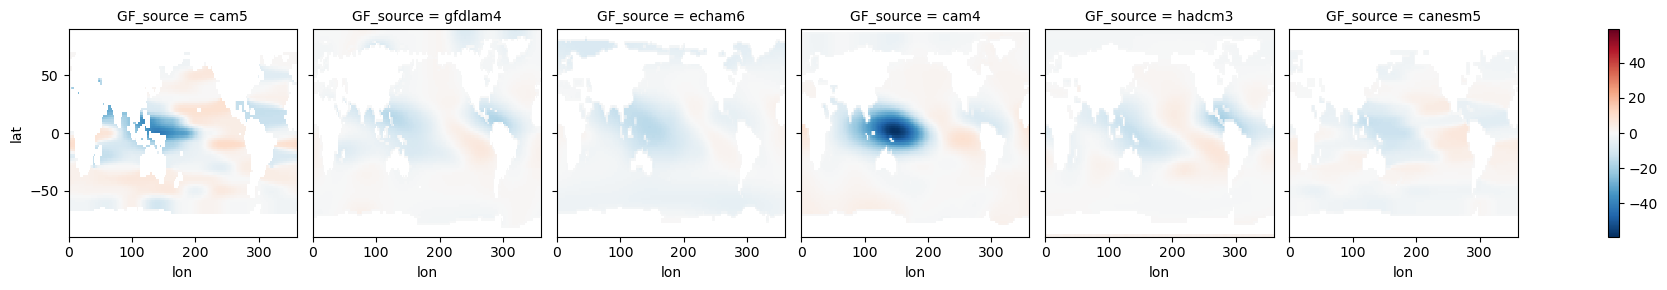

In [4]:
grid_out_2deg = grid_out_2deg = xr.Dataset({'lat': (['lat'], np.arange(-89, 90, 2.)),
                          'lon': (['lon'], np.arange(1, 360, 2.))})

gf_directory = '/projets/EMC2/data/Models/GFMIP/preliminary_spatial_feedbacks-main/data/'

all_GF = []

for file in os.listdir(gf_directory):
    GF_raw = xr.open_dataset(f"{gf_directory}/{file}")
    da = GF_raw.spatial_feedbacks_from_warming if file == 'cam4.nc' else GF_raw.spatial_feedbacks_from_both

    regridded_da_old_consnorm = xe.Regridder(da, grid_out_2deg, 'conservative_normed', periodic=True)(da)
    regridded_da_old_consnorm = regridded_da_old_consnorm.where(regridded_da_old_consnorm!=0)
    all_GF.append(regridded_da_old_consnorm.assign_coords(GF_source=file.split('.')[0]))

GF = xr.concat(all_GF, dim='GF_source')
GF.plot(col='GF_source')
# grid_out_2deg_mask = grid_out_2deg = xr.Dataset({'lat': (['lat'], np.arange(-89, 90, 2.)),
#                           'lon': (['lon'], np.arange(1, 360, 2.))})
# grid_out_2deg_mask['mask'] = ds_tos.isel(time=1000,product=0, drop=True).notnull().astype(int)



# GF_raw = xr.open_dataset(f"{gf_directory}/cam5.nc")
# da = GF_raw.spatial_feedbacks_from_both

# regridded_da_old_consnorm = xe.Regridder(da, grid_out_2deg, 'conservative_normed', periodic=True)(da)
# regridded_da_old_consnorm = regridded_da_old_consnorm.where(regridded_da_old_consnorm!=0)

# regridded_da_old_bil = xe.Regridder(da, grid_out_2deg, 'bilinear', periodic=True)(da)
# regridded_da_old_bil = regridded_da_old_bil.where(regridded_da_old_bil!=0)

# fig, axs = plt.subplots(1,3, figsize=(12,2))
# da.plot(ax=axs[0])
# regridded_da_old_consnorm.plot(ax=axs[1])
# regridded_da_old_bil.plot(ax=axs[2])

In [9]:
grid_out_t42 = xr.open_dataset('/scratchx/rguillaume/data/tos_jasmin/cobe2_sst.nc').isel(time=0, drop=True).sst

In [71]:
gf_directory = '/projets/EMC2/data/Models/GFMIP/preliminary_spatial_feedbacks-main/data/'
list_gf_models = os.listdir(gf_directory)


list_gf_regridded = []
for model in tqdm(list_gf_models):
    with xr.open_dataset(f"{gf_directory}/{model}") as ds_raw:
        if "spatial_feedbacks_from_both" in ds_raw.variables:
            data = ds_raw.spatial_feedbacks_from_both
        else:
            data = ds_raw.spatial_feedbacks_from_warming
    regridded_data = xe.Regridder(data, grid_out_2deg, 'conservative_normed', periodic=True)(data).assign_coords(GF_source=model.split('.')[0])
    regridded_data = regridded_data.where(regridded_data!=0)
    # weights = xr.ones_like(regridded_data).where(regridded_data.notnull())*(np.cos(np.deg2rad(regridded_data.lat)))
    # total = weights.sum(['lon','lat'])
    # weights_normed = weights/total
    # regridded_data_normed = regridded_data*weights_normed
    ds_model = xr.Dataset(dict(GF=regridded_data))
    list_gf_regridded.append(ds_model)
    
greens_functions = xr.concat(list_gf_regridded, dim='GF_source' )
# greens_functions['GF'] = greens_functions.where(greens_functions.GF!=0)
greens_functions_mean = greens_functions.where(greens_functions.count('GF_source')==greens_functions.count('GF_source').max()).mean('GF_source')
greens_functions_2deg = xr.concat([greens_functions_mean.assign_coords(GF_source='mean'), greens_functions], dim='GF_source')

  0%|          | 0/6 [00:00<?, ?it/s]

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'longitude_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'longitude_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'longitude_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'longitude_bn

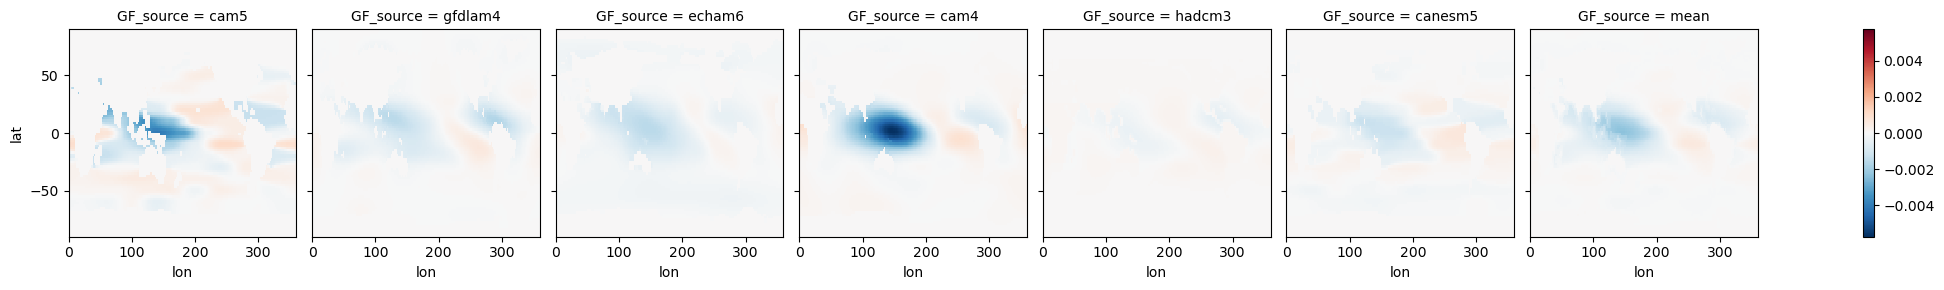

In [33]:
GF_names = dict(cam4='CAM4',cam5='CAM5', canesm5='CanESM5', echam6='ECHAM6', gfdlam4='GFDL-AM4',hadcm3='HadCM3')

GF_DIR = '/projets/EMC2/data/Models/GFMIP/preliminary_spatial_feedbacks-main/data/'
list_gfs = [k.split('.')[0] for k in os.listdir(GF_DIR)]
all_gfs = []
for gf in list_gfs:
    ds = xr.open_dataset(f"{GF_DIR}/{gf}.nc").rename(longitude='lon', latitude='lat')
    if gf=='cam4':
        da = ds.spatial_feedbacks_from_warming
    else:
        da = ds.spatial_feedbacks_from_both
    ds['mask'] = (da!=0).astype(int)
    grid_out
    regridder_gf = xe.Regridder(ds, grid_out, 'conservative_normed', periodic=True)
    GF_regridded = regridder_gf(da).assign_coords(GF_source=gf)

    all_gfs.append(GF_regridded)
GF = xr.concat(all_gfs, dim='GF_source')

# GF = GF.where(GF.count('GF_source')==GF.count('GF_source').max(),0)
GF = xr.concat([GF, 
                GF.mean('GF_source').assign_coords(GF_source='mean')], dim='GF_source')
def fill2d(arr, x, y):
    xx, yy = np.meshgrid(x, y)
    points = np.column_stack((xx.ravel(), yy.ravel()))
    mask = ~np.isnan(arr.ravel())
    return griddata(points[mask], arr.ravel()[mask], points, method="linear").reshape(arr.shape)

GF_filled = xr.apply_ufunc(
    fill2d, GF.where(GF!=0), GF.lon, GF.lat,
    input_core_dims=[["lat","lon"], ["lon"], ["lat"]],
    output_core_dims=[["lat","lon"]],
    vectorize=True,
    dask="parallelized",
)



GF_filled = GF_filled.where(ds_tos.isel(time=1245, product=0).notnull())

greens_functions_2deg_new = GF_filled


cell_area = xr.zeros_like(ds_tos.isel(product=0, time=0))+np.cos(np.deg2rad(ds_tos.lat))
cell_ratio = cell_area/cell_area.sum(['lon','lat'])
GF_normed = (GF*cell_ratio).fillna(0)

GF_normed.plot(col='GF_source')

GF = GF_normed



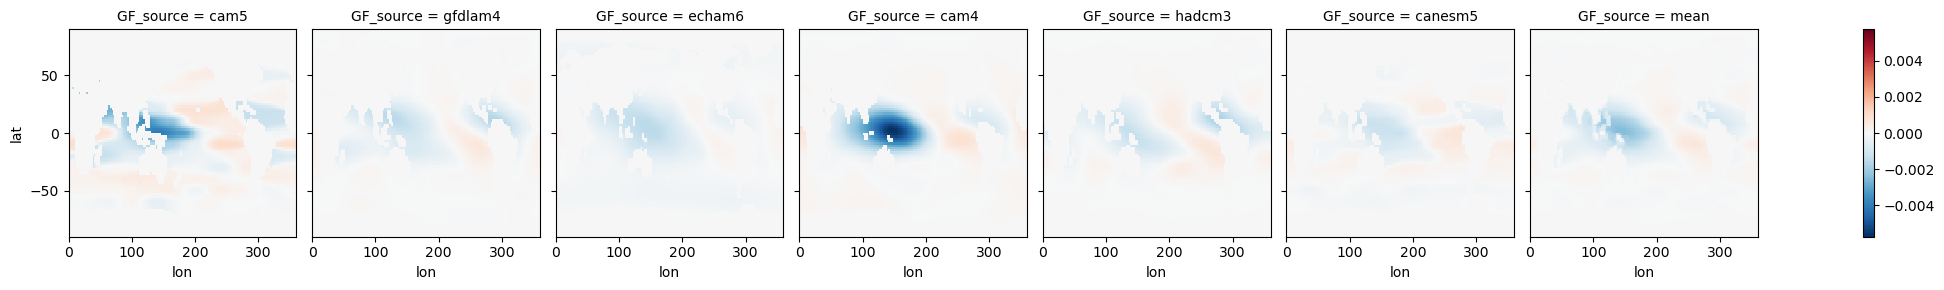

In [39]:
GF_names = dict(cam4='CAM4',cam5='CAM5', canesm5='CanESM5', echam6='ECHAM6', gfdlam4='GFDL-AM4',hadcm3='HadCM3')

GF_DIR = '/projets/EMC2/data/Models/GFMIP/preliminary_spatial_feedbacks-main/data/'
list_gfs = [k.split('.')[0] for k in os.listdir(GF_DIR)]
all_gfs = []
for gf in list_gfs:
    ds = xr.open_dataset(f"{GF_DIR}/{gf}.nc").rename(longitude='lon', latitude='lat')
    if gf=='cam4':
        da = ds.spatial_feedbacks_from_warming
    else:
        da = ds.spatial_feedbacks_from_both
    ds['mask'] = (da!=0).astype(int)
    grid_out
    regridder_gf = xe.Regridder(ds, grid_out, 'bilinear', periodic=True)
    GF_regridded = regridder_gf(da).assign_coords(GF_source=gf)

    all_gfs.append(GF_regridded)
GF = xr.concat(all_gfs, dim='GF_source')

# GF = GF.where(GF.count('GF_source')==GF.count('GF_source').max(),0)
GF = xr.concat([GF, 
                GF.mean('GF_source').assign_coords(GF_source='mean')], dim='GF_source')
def fill2d(arr, x, y):
    xx, yy = np.meshgrid(x, y)
    points = np.column_stack((xx.ravel(), yy.ravel()))
    mask = ~np.isnan(arr.ravel())
    return griddata(points[mask], arr.ravel()[mask], points, method="linear").reshape(arr.shape)

GF_filled = xr.apply_ufunc(
    fill2d, GF.where(GF!=0), GF.lon, GF.lat,
    input_core_dims=[["lat","lon"], ["lon"], ["lat"]],
    output_core_dims=[["lat","lon"]],
    vectorize=True,
    dask="parallelized",
)



GF_filled = GF_filled.where(ds_tos.isel(time=1245, product=0).notnull())

greens_functions_2deg_new_bilinear = GF_filled


cell_area = xr.zeros_like(ds_tos.isel(product=0, time=0))+np.cos(np.deg2rad(ds_tos.lat))
cell_ratio = cell_area/cell_area.sum(['lon','lat'])
GF_normed = (GF*cell_ratio).fillna(0)

GF_normed.plot(col='GF_source')

GF = GF_normed



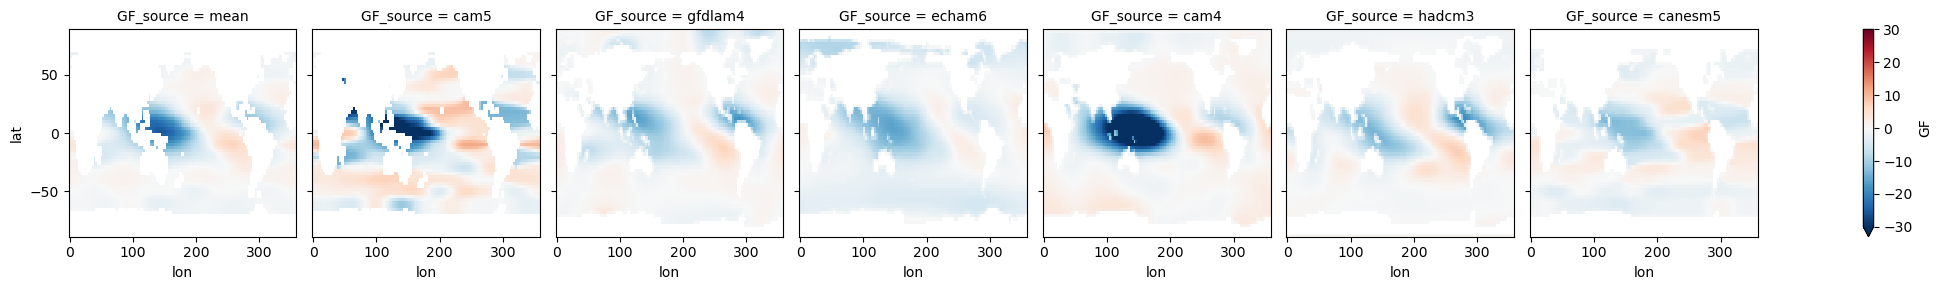

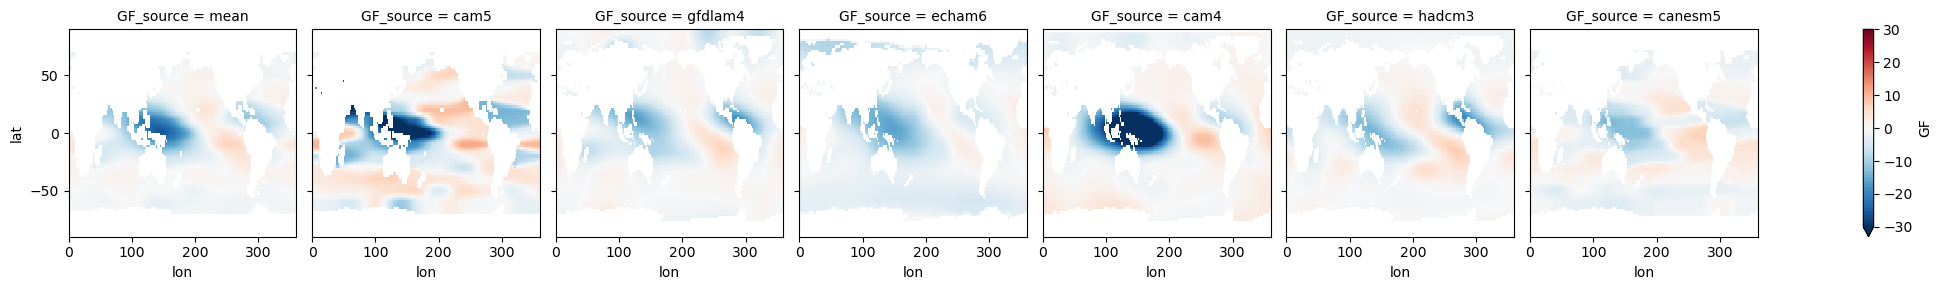

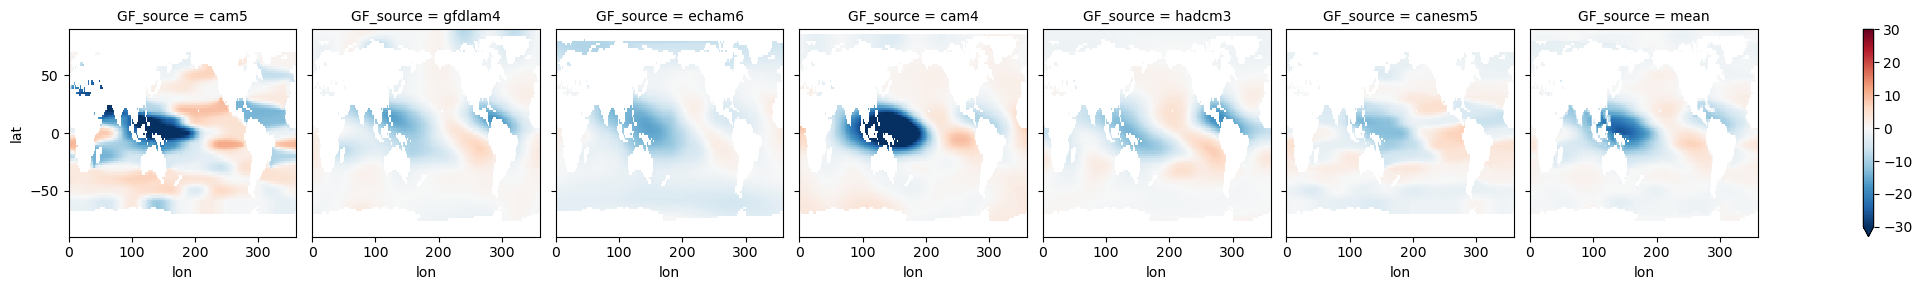

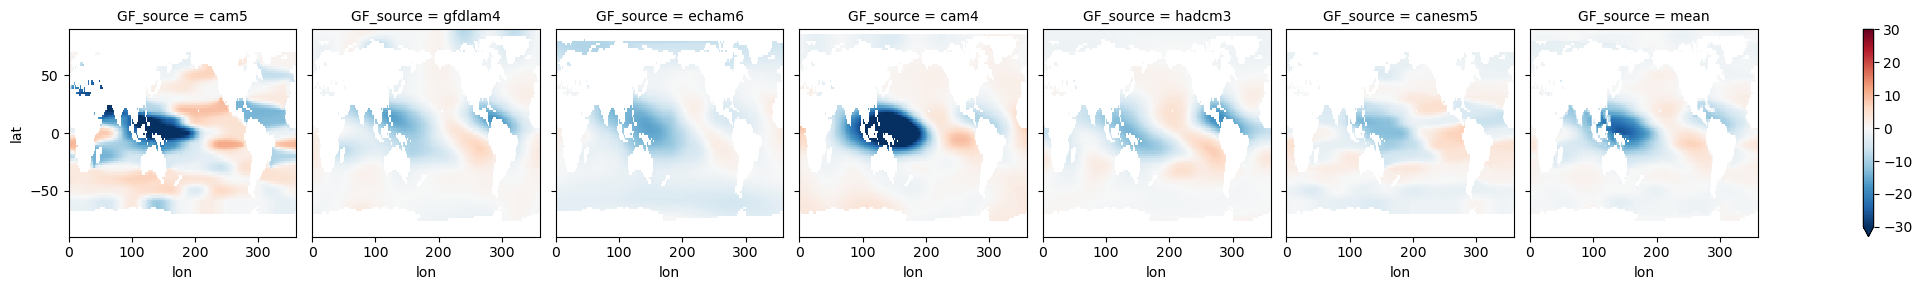

In [40]:
greens_functions_t42.GF.plot(col='GF_source', vmax=30)
greens_functions_2deg.GF.plot(col='GF_source', vmax=30)
greens_functions_2deg_new.plot(col='GF_source', vmax=30)
greens_functions_2deg_new_bilinear.plot(col='GF_source', vmax=30)

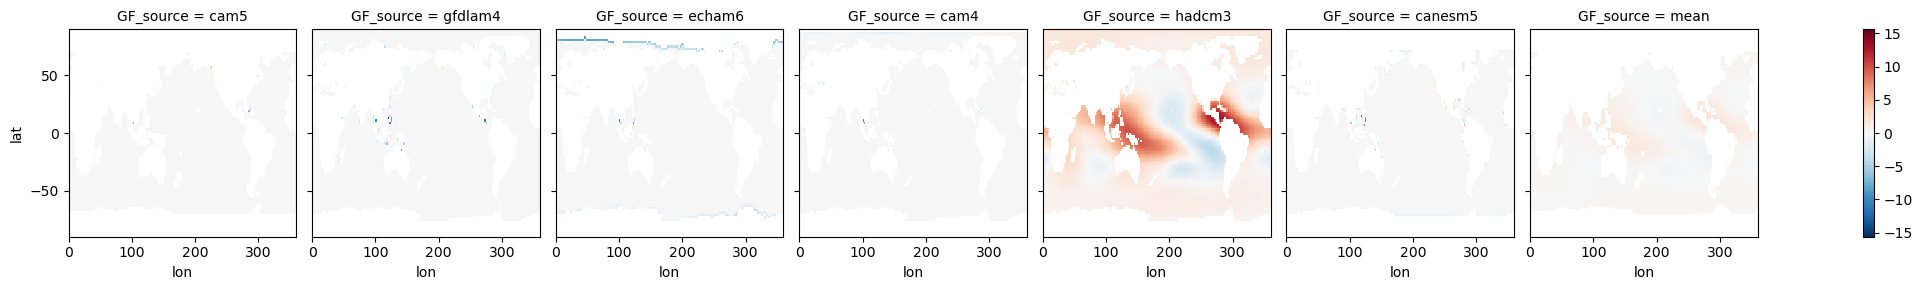

In [36]:
(greens_functions_2deg_new - greens_functions_2deg.GF).plot(col='GF_source')

NameError: name 'greens_functions' is not defined